## Test: Calculating Flux and Magnitudes

Using MCMC results to calculate an array of flux measurements.

In [3]:
### IMPORTS

import os
import sys

# math, array manipulation, etc.
import numpy as np

# timing
from timeit import default_timer

# data structures from astropy
import astropy.io.fits as fits
from astropy.table import Table

# astronomical image fitting software Imfit, wrapped in Python
# https://github.com/perwin/pyimfit
# https://pyimfit.readthedocs.io/en/latest/
import pyimfit

# MCMC sampling package
import emcee

# necessary utilities from scipy, astropy, and photutils
from scipy.ndimage import maximum_filter
from scipy.stats import multivariate_normal
from astropy.stats import SigmaClip, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
from photutils.background import Background2D, StdBackgroundRMS
from photutils.segmentation import detect_sources, SegmentationImage, deblend_sources

# plots
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

sys.path.append('/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/')

from imfit_mcmc import SersicMCMC

In [4]:
# the following commands make plots look better
def plot_prettier(dpi=200, fontsize=10): 
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in')
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    # if you don't have LaTeX installed on your laptop and this statement 
    # generates error, comment it out
    plt.rc('text', usetex=True)
    
plot_prettier()

In [8]:
def read_fits_table(filename):
    '''
    reads and returns data in a table from a FITS file
    '''
    hdu = fits.open(filename)
    data = Table(hdu[1].data)   # second index of the hdu corresponds to the data in my astropy table files
    hdu.close()
    
    return data

def read_fits_image(filename):
    '''
    reads and returns an image from a FITS file
    '''
    hdu = fits.open(filename)
    data = hdu[0].data
    header = hdu[0].header 
    hdu.close()
    
    return data

def get_files(path):
    files = np.array(os.listdir(path))
    finds = sorted([i for i, f in enumerate(files) if '.fits' in f])
    files = files[finds]
    return files

In [9]:
jr_path = '/Users/aidan/Desktop/sl_project/datasets/sl_jacobs/rband_dr2/'
jg_path = '/Users/aidan/Desktop/sl_project/datasets/sl_jacobs/gband_dr2/'

files_r = get_files(jr_path)
files_g = get_files(jg_path)

In [17]:
index = 3
file_r = os.path.join(jr_path, files_r[index])
file_g = os.path.join(jg_path, files_g[index])

img_r = read_fits_image(file_r)
img_g = read_fits_image(file_g)
#test_img_r = read_fits_image('/Users/aidan/Downloads/DESJ031253.9220-130825.4832_r.fits')
#test_img_g = read_fits_image('/Users/aidan/Downloads/DESJ031253.9220-130825.4832_g.fits')

nrow, ncol = img_r.shape
split = file_r.split('/')[-1].split('.')
desid = split[0][:-2] + split[1][4:7]
print(desid)

DESJ0342-53


In [18]:
# getting standard deviation of Gaussian PSF model

fwhm_r = 0.95 * u.arcsec
fwhm_g = 1.11 * u.arcsec

# length of one side of the image
length = 0.31 * u.arcmin

# arcsec per pixel
arcsec_pix = 0.263

test_arr = np.zeros_like(img_r)
all_inds = np.argwhere(test_arr == 0)

dist2cent = np.linalg.norm(all_inds - (np.array([nrow, ncol])-1)/2, axis=1).reshape(nrow, ncol)
print((np.array([nrow, ncol])-1)/2)

fwhm_pix_r = fwhm_r.value / arcsec_pix
fwhm_pix_g = fwhm_g.value / arcsec_pix

#print(fwhm_pix_r, fwhm_pix_g)

std_psf_r = fwhm_pix_r / (2 * np.sqrt(2 * np.log(2)))
std_psf_g = fwhm_pix_g / (2 * np.sqrt(2 * np.log(2)))

[35. 35.]


In [19]:
test = SersicMCMC(img_r = img_r, img_g = img_g
                  , std_psf_r = std_psf_r, std_psf_g = std_psf_g
                  , desid = desid
                 )

/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/imfit_mcmc.py:164: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)
/Users/aidan/Desktop/sl_project/galaxy-galaxy-sel/imfit_mcmc.py:164: RuntimeWarning: invalid value encountered in sqrt
  std_gal = np.sqrt(num * img_gal)


  0%|          | 0/1000 [00:00<?, ?it/s]

r band:
             aic: 2733.51496054007
            bic: 2779.1702256893022
   fitConverged: True
        fitStat: 2719.492707410724
 fitStatReduced: 0.5402250114045936
          nIter: 16
      paramErrs: array([0.04638586, 0.04278632, 5.14087446, 0.01875517, 0.06694521,
       1.54095349, 0.12525444])
         params: array([35.42988058, 36.6989414 , 89.47861808,  0.11012726,  1.6124417 ,
       36.76181192,  5.503598  ])
     solverName: 'LM'

g band:
             aic: 2206.245839690993
            bic: 2251.9011048402253
   fitConverged: True
        fitStat: 2192.2235865616467
 fitStatReduced: 0.43548342998840817
          nIter: 17
      paramErrs: array([0.13600738, 0.15316645, 5.50946975, 0.0329829 , 0.04357159,
       0.54147309, 0.16826329])
         params: array([ 36.4944653 ,  35.03718938, 154.9409698 ,   0.18386649,
         0.41073894,  11.94443042,   6.02124192])
     solverName: 'LM'


100%|██████████| 1000/1000 [02:52<00:00,  5.81it/s]


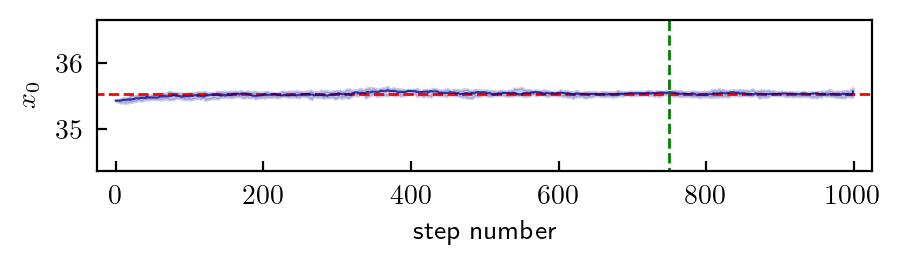

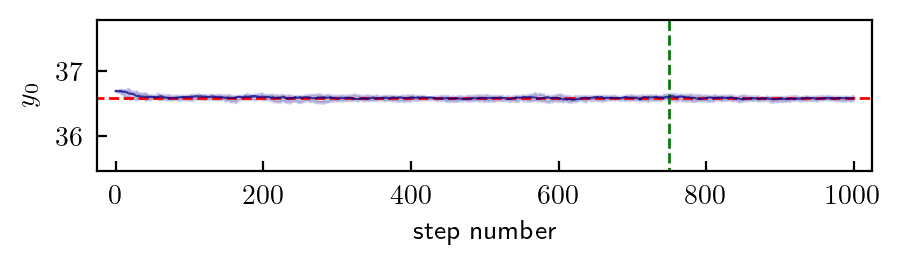

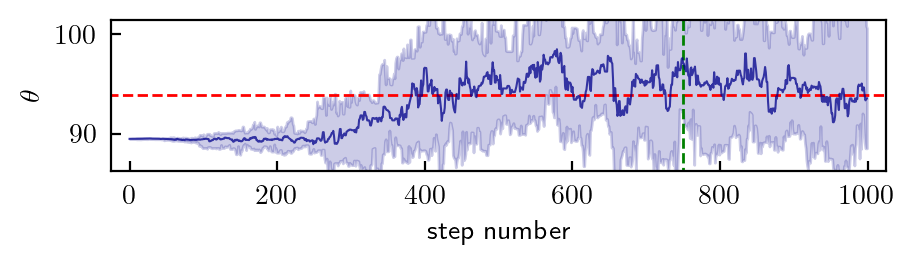

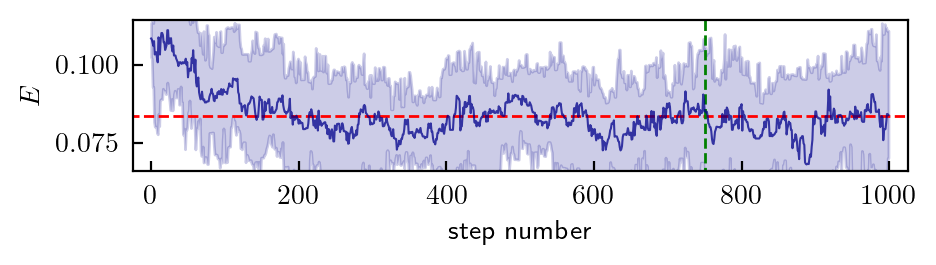

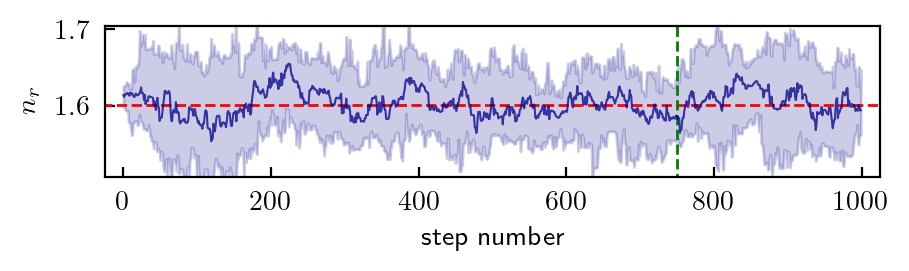

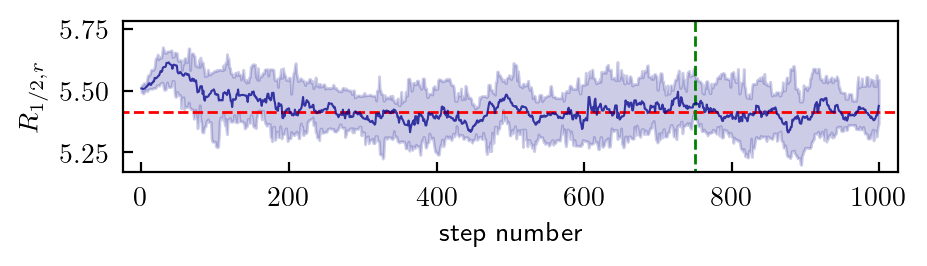

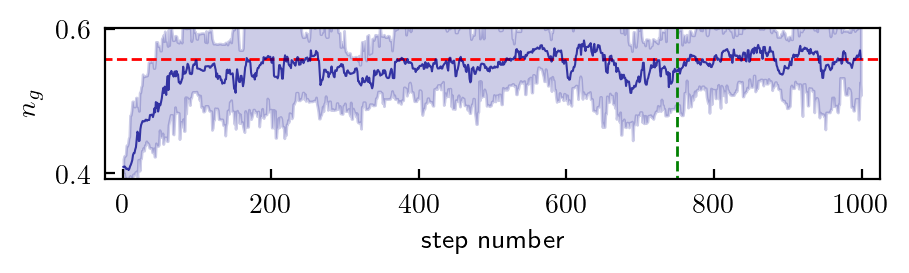

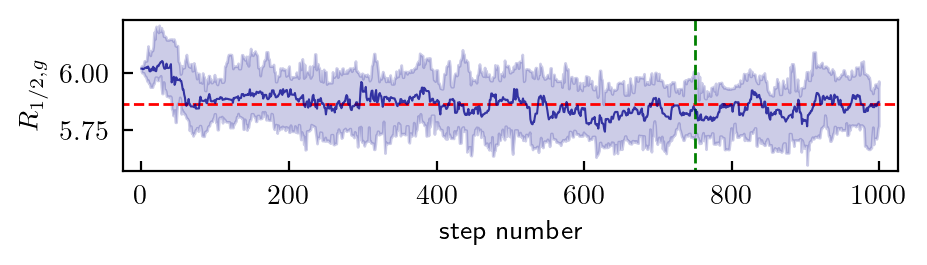

In [20]:
run, dist = test.mcmc_run(nwalkers=20, steps=1000)
    
test.plot_trace()

# plot model result
test.plot_gal()

----------------------------



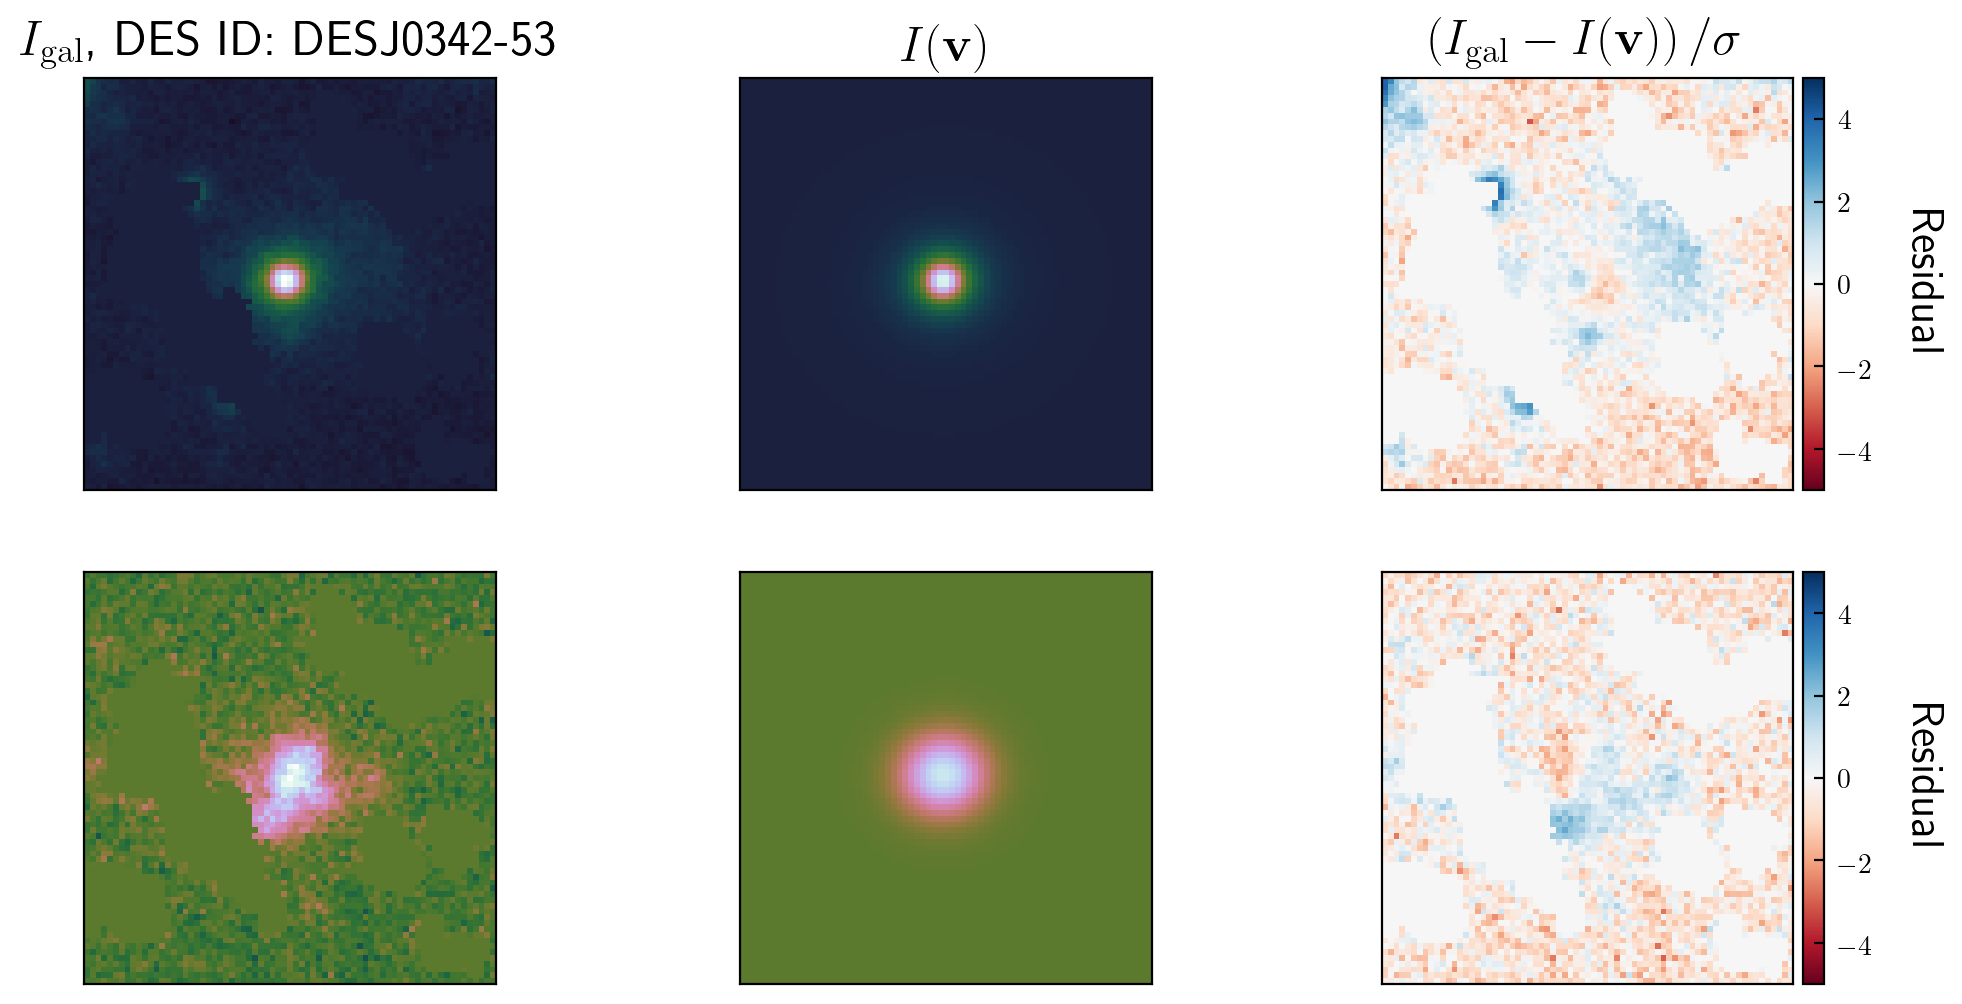

In [21]:
# plot model result

test.plot_gal()